[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/BinaWu/DeepLearning_Python/blob/master/3_6_ScalarRegression.ipynb)

Using TensorFlow backend.


57344/57026 [==============================] - 0s 7us/step
processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3
processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


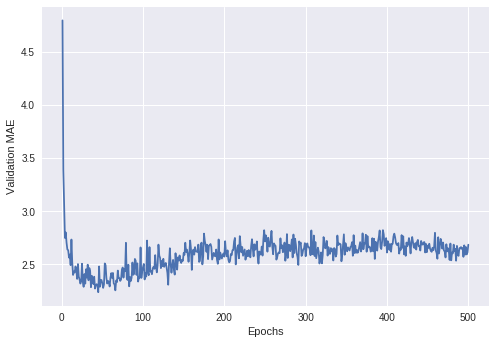

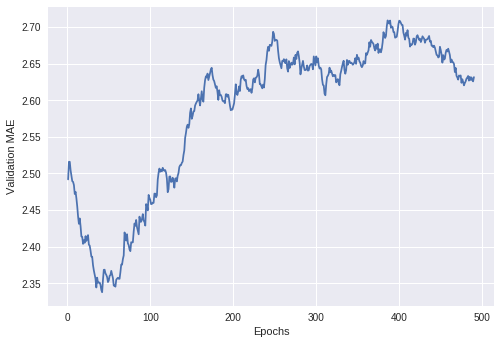

102/102 [==============================] - 0s 939us/step


2.6750134393280627

In [1]:
from keras.datasets import boston_housing
(train_data, train_targets), (test_data, test_targets) =boston_housing.load_data()

#Normalizing the data
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std
test_data -= mean
test_data /= std

from keras import models
from keras import layers
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))  #輸出值設為1 且不設activation 則會輸出一個數值，若activation=sigmoid 則值會界於0和1之間
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

#K-fold validation
import numpy as np
k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []

for i in range(k):
    print('processing fold #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate([train_data[:i * num_val_samples],train_data[(i + 1) * num_val_samples:]],axis=0)
    partial_train_targets = np.concatenate([train_targets[:i * num_val_samples],train_targets[(i + 1) * num_val_samples:]],axis=0)
    model = build_model()
    model.fit(partial_train_data, partial_train_targets,epochs=num_epochs, batch_size=1, verbose=0)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

#Saving the validation logs at each fold
num_epochs = 500
all_mae_histories = []
for i in range(k):
    print('processing fold #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate([train_data[:i * num_val_samples],train_data[(i + 1) * num_val_samples:]],axis=0)
    partial_train_targets = np.concatenate([train_targets[:i * num_val_samples],train_targets[(i + 1) * num_val_samples:]],axis=0)
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets,validation_data=(val_data, val_targets),epochs=num_epochs, batch_size=1, verbose=0)
    mae_history = history.history['val_mean_absolute_error']
    all_mae_histories.append(mae_history)

#算出平均值
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

#畫MAE的曲線圖
import matplotlib.pyplot as plt
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

#將上圖資料轉換畫出更平滑的曲線
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points
smooth_mae_history = smooth_curve(average_mae_history[10:])
plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

#Training the final model
model = build_model()
model.fit(train_data, train_targets,epochs=80, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

test_mae_score